In this tutorial I’ll explain how to build a simple working 
Recurrent Neural Network in TensorFlow! 

We will build a simple Echo-RNN that remembers the input sequence and then echoes it after a few time-steps. This will help us understand how
memory works 

We are mapping two sequences!

# What is an RNN?
It is short for “Recurrent Neural Network”, and is basically a neural 
network that can be used when your data is treated as a sequence, where 
the particular order of the data-points matter. More importantly, this 
sequence can be of arbitrary length.

The most straight-forward example is perhaps a time-seriedems of numbers, 
where the task is to predict the next value given previous values. The 
input to the RNN at every time-step is the current value as well as a 
state vector which represent what the network has “seen” at time-steps 
before. This state-vector is the encoded memory of the RNN, initially 
set to zero.

Great paper on this 
https://arxiv.org/pdf/1506.00019.pdf

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 
from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
Image(url= "https://cdn-images-1.medium.com/max/1600/1*UkI9za9zTR-HL8uM15Wmzw.png")

In [3]:
#hyperparams

num_epochs = 100
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length

In [4]:
#Step 1 - Collect data
#Now generate the training data, 
#the input is basically a random binary vector. The output will be the 
#“echo” of the input, shifted echo_step steps to the right.

#Notice the reshaping of the data into a matrix with batch_size rows. 
#Neural networks are trained by approximating the gradient of loss function 
#with respect to the neuron-weights, by looking at only a small subset of the data, 
#also known as a mini-batch.The reshaping takes the whole dataset and puts it into 
#a matrix, that later will be sliced up into these mini-batches.

def generateData():
    #0,1, 50K samples, 50% chance each chosen
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    print(x.shape)
    #shift 3 steps to the left
    y = np.roll(x, echo_step)
    #padd beginning 3 values with 0
    y[0:echo_step] = 0
    #Gives a new shape to an array without changing its data.
    #The reshaping takes the whole dataset and puts it into a matrix, 
    #that later will be sliced up into these mini-batches.
    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))
    print(x.shape)
    return (x, y)

data = generateData()

print(data)

(50000,)
(5, 10000)
(array([[1, 0, 0, ..., 1, 0, 1],
       [0, 1, 0, ..., 0, 1, 1],
       [0, 1, 1, ..., 0, 1, 1],
       [1, 0, 1, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 0, 1]], dtype=int64), array([[0, 0, 0, ..., 0, 1, 1],
       [1, 0, 1, ..., 0, 1, 1],
       [0, 1, 1, ..., 1, 1, 1],
       [0, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 0, 1, 0]], dtype=int64))


In [5]:
#Schematic of the reshaped data-matrix, arrow curves shows adjacent time-steps that ended up on different rows. 
#Light-gray rectangle represent a “zero” and dark-gray a “one”.
Image(url= "https://cdn-images-1.medium.com/max/1600/1*aFtwuFsboLV8z5PkEzNLXA.png")

In [6]:
#TensorFlow works by first building up a computational graph, that 
#specifies what operations will be done. The input and output of this graph
#is typically multidimensional arrays, also known as tensors. 
#The graph, or parts of it can then be executed iteratively in a 
#session, this can either be done on the CPU, GPU or even a resource 
#on a remote server.

#operations and tensors

#The two basic TensorFlow data-structures that will be used in this 
#example are placeholders and variables. On each run the batch data 
#is fed to the placeholders, which are “starting nodes” of the 
#computational graph. Also the RNN-state is supplied in a placeholder, 
#which is saved from the output of the previous run.

#Step 2 - Build the Model

#datatype, shape (5, 15) 2D array or matrix, batch size shape for later
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

#and one for the RNN state, 5,4 
init_state = tf.placeholder(tf.float32, [batch_size, state_size])

In [7]:
#The weights and biases of the network are declared as TensorFlow variables,
#which makes them persistent across runs and enables them to be updated
#incrementally for each batch.

#3 layer recurrent net, one hidden state

#randomly initialize weights
W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
#anchor, improves convergance, matrix of 0s 
b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

The figure below shows the input data-matrix, and the current batch batchX_placeholder 
is in the dashed rectangle. As we will see later, this “batch window” is slided truncated_backprop_length 
steps to the right at each run, hence the arrow. In our example below batch_size = 3, truncated_backprop_length = 3, 
and total_series_length = 36. Note that these numbers are just for visualization purposes, the values are different in the code. 
The series order index is shown as numbers in a few of the data-points.

In [8]:
Image(url= "https://cdn-images-1.medium.com/max/1600/1*n45uYnAfTDrBvG87J-poCA.jpeg")

In [9]:
#Now it’s time to build the part of the graph that resembles the actual RNN computation, 
#first we want to split the batch data into adjacent time-steps.

# Unpack columns
#Unpacks the given dimension of a rank-R tensor into rank-(R-1) tensors.
#so a bunch of arrays, 1 batch per time step
inputs_series = tf.unstack(batchX_placeholder, axis=1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

As you can see in the picture below that is done by unpacking the columns (axis = 1) of the batch into a Python list. The RNN will simultaneously be training on different parts in the time-series; steps 4 to 6, 16 to 18 and 28 to 30 in the current batch-example. The reason for using the variable names “plural”_”series” is to emphasize that the variable is a list that represent a time-series with multiple entries at each step.

In [10]:
Image(url= "https://cdn-images-1.medium.com/max/1600/1*f2iL4zOkBUBGOpVE7kyajg.png")
#Schematic of the current batch split into columns, the order index is shown on each data-point 
#and arrows show adjacent time-steps.

The fact that the training is done on three places simultaneously in our time-series, requires us to save three instances of states when propagating forward. That has already been accounted for, as you see that the init_state placeholder has batch_size rows.


In [11]:
#Forward pass
#state placeholder
current_state = init_state
#series of states through time
states_series = []


#for each set of inputs
#forward pass through the network to get new state value
#store all states in memory
for current_input in inputs_series:
    #format input
    current_input = tf.reshape(current_input, [batch_size, 1])
    #mix both state and input data 
    input_and_state_concatenated = tf.concat([current_input, current_state],1)  # Increasing number of columns
    #perform matrix multiplication between weights and input, add bias
    #squash with a nonlinearity, for probabiolity value
    print(input_and_state_concatenated)
    print(W)
    next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)  # Broadcasted addition
    #store the state in memory
    states_series.append(next_state)
    #set current state to next one
    current_state = next_state


Tensor("concat:0", shape=(5, 5), dtype=float32)
<tf.Variable 'Variable:0' shape=(5, 4) dtype=float32_ref>
Tensor("concat_1:0", shape=(5, 5), dtype=float32)
<tf.Variable 'Variable:0' shape=(5, 4) dtype=float32_ref>
Tensor("concat_2:0", shape=(5, 5), dtype=float32)
<tf.Variable 'Variable:0' shape=(5, 4) dtype=float32_ref>
Tensor("concat_3:0", shape=(5, 5), dtype=float32)
<tf.Variable 'Variable:0' shape=(5, 4) dtype=float32_ref>
Tensor("concat_4:0", shape=(5, 5), dtype=float32)
<tf.Variable 'Variable:0' shape=(5, 4) dtype=float32_ref>
Tensor("concat_5:0", shape=(5, 5), dtype=float32)
<tf.Variable 'Variable:0' shape=(5, 4) dtype=float32_ref>
Tensor("concat_6:0", shape=(5, 5), dtype=float32)
<tf.Variable 'Variable:0' shape=(5, 4) dtype=float32_ref>
Tensor("concat_7:0", shape=(5, 5), dtype=float32)
<tf.Variable 'Variable:0' shape=(5, 4) dtype=float32_ref>
Tensor("concat_8:0", shape=(5, 5), dtype=float32)
<tf.Variable 'Variable:0' shape=(5, 4) dtype=float32_ref>
Tensor("concat_9:0", shape=(5,

Notice the concatenation on line 6, what we actually want to do is calculate the sum of two affine transforms current_input * Wa + current_state * Wb in the figure below. By concatenating those two tensors you will only use one matrix multiplication. The addition of the bias b is broadcasted on all samples in the batch.

In [12]:
Image(url= "https://cdn-images-1.medium.com/max/1600/1*fdwNNJ5UOE3Sx0R_Cyfmyg.png")

You may wonder the variable name truncated_backprop_length is supposed to mean. When a RNN is trained, it is actually treated as a deep neural network with reoccurring weights in every layer. These layers will not be unrolled to the beginning of time, that would be too computationally expensive, and are therefore truncated at a limited number of time-steps. In our sample schematics above, the error is backpropagated three steps in our batch

In [14]:
#calculate loss
#second part of forward pass
#logits short for logistic transform
logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
print(logits_series)
print(labels_series)
#apply softmax nonlinearity for output probability
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

#measure loss, calculate softmax again on logits, then compute cross entropy
#measures the difference between two probability distributions
#this will return A Tensor of the same shape as labels and of the same type as logits 
#with the softmax cross entropy loss.
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits, labels in zip(logits_series,labels_series)]
#computes average, one value
total_loss = tf.reduce_mean(losses)
#use adagrad to minimize with .3 learning rate
#minimize it with adagrad, not SGD
#One downside of SGD is that it is sensitive to
#the learning rate hyper-parameter. When the data are sparse and features have
#different frequencies, a single learning rate for every weight update can have
#exponential regret.
#Some features can be extremely useful and informative to an optimization problem but 
#they may not show up in most of the training instances or data. If, when they do show up, 
#they are weighted equally in terms of learning rate as a feature that has shown up hundreds 
#of times we are practically saying that the influence of such features means nothing in the 
#overall optimization. it's impact per step in the stochastic gradient descent will be so small 
#that it can practically be discounted). To counter this, AdaGrad makes it such that features 
#that are more sparse in the data have a higher learning rate which translates into a larger 
#update for that feature
#sparse features can be very useful.
#Each feature has a different learning rate which is adaptable. 
#gives voice to the little guy who matters a lot
#weights that receive high gradients will have their effective learning rate reduced, 
#while weights that receive small or infrequent updates will have their effective learning rate increased. 
#great paper http://seed.ucsd.edu/mediawiki/images/6/6a/Adagrad.pdf
train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

[<tf.Tensor 'add_30:0' shape=(5, 2) dtype=float32>, <tf.Tensor 'add_31:0' shape=(5, 2) dtype=float32>, <tf.Tensor 'add_32:0' shape=(5, 2) dtype=float32>, <tf.Tensor 'add_33:0' shape=(5, 2) dtype=float32>, <tf.Tensor 'add_34:0' shape=(5, 2) dtype=float32>, <tf.Tensor 'add_35:0' shape=(5, 2) dtype=float32>, <tf.Tensor 'add_36:0' shape=(5, 2) dtype=float32>, <tf.Tensor 'add_37:0' shape=(5, 2) dtype=float32>, <tf.Tensor 'add_38:0' shape=(5, 2) dtype=float32>, <tf.Tensor 'add_39:0' shape=(5, 2) dtype=float32>, <tf.Tensor 'add_40:0' shape=(5, 2) dtype=float32>, <tf.Tensor 'add_41:0' shape=(5, 2) dtype=float32>, <tf.Tensor 'add_42:0' shape=(5, 2) dtype=float32>, <tf.Tensor 'add_43:0' shape=(5, 2) dtype=float32>, <tf.Tensor 'add_44:0' shape=(5, 2) dtype=float32>]
[<tf.Tensor 'unstack_1:0' shape=(5,) dtype=int32>, <tf.Tensor 'unstack_1:1' shape=(5,) dtype=int32>, <tf.Tensor 'unstack_1:2' shape=(5,) dtype=int32>, <tf.Tensor 'unstack_1:3' shape=(5,) dtype=int32>, <tf.Tensor 'unstack_1:4' shape=(5

The last line is adding the training functionality, TensorFlow will perform back-propagation for us automatically — the computation graph is executed once for each mini-batch and the network-weights are updated incrementally.

Notice the API call to sparse_softmax_cross_entropy_with_logits, it automatically calculates the softmax internally and then computes the cross-entropy. In our example the classes are mutually exclusive (they are either zero or one), which is the reason for using the “Sparse-softmax”, you can read more about it in the API. The usage is to havelogits is of shape [batch_size, num_classes] and labels of shape [batch_size].

In [27]:
#visualizer
def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)

There is a visualization function so we can se what’s going on in the network as we train. It will plot the loss over the time, show training input, training output and the current predictions by the network on different sample series in a training batch.

Instructions for updating:
Use `tf.global_variables_initializer` instead.


(50000,)
(5, 10000)
New data, epoch 0
Step 0 Loss 0.668468
Step 100 Loss 0.694434
Step 200 Loss 0.695671
Step 300 Loss 0.695655
Step 400 Loss 0.692465
Step 500 Loss 0.229034
Step 600 Loss 0.0244447
(50000,)
(5, 10000)
New data, epoch 1
Step 0 Loss 0.224086
Step 100 Loss 0.00937365
Step 200 Loss 0.00694738
Step 300 Loss 0.00502159
Step 400 Loss 0.00473592
Step 500 Loss 0.00391119
Step 600 Loss 0.00296023
(50000,)
(5, 10000)
New data, epoch 2
Step 0 Loss 0.170412
Step 100 Loss 0.00418357
Step 200 Loss 0.00332037
Step 300 Loss 0.00294459
Step 400 Loss 0.00280294
Step 500 Loss 0.00220706
Step 600 Loss 0.0021553
(50000,)
(5, 10000)
New data, epoch 3
Step 0 Loss 0.229209


KeyboardInterrupt: 

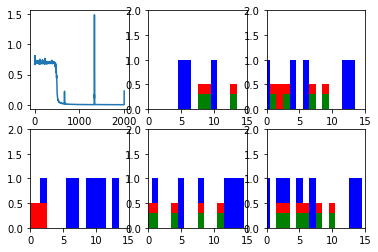

In [28]:
#Step 3 Training the network
with tf.Session() as sess:
    #we stupidly have to do this everytime, it should just know
    #that we initialized these vars. v2 guys, v2..
    sess.run(tf.global_variables_initializer())
    #interactive mode
    plt.ion()
    #initialize the figure
    plt.figure()
    #show the graph
    plt.show()
    #to show the loss decrease
    loss_list = []

    for epoch_idx in range(num_epochs):
        #generate data at eveery epoch, batches run in epochs
        x,y = generateData()
        #initialize an empty hidden state
        _current_state = np.zeros((batch_size, state_size))

        print("New data, epoch", epoch_idx)
        #each batch
        for batch_idx in range(num_batches):
            #starting and ending point per batch
            #since weights reoccuer at every layer through time
            #These layers will not be unrolled to the beginning of time, 
            #that would be too computationally expensive, and are therefore truncated 
            #at a limited number of time-steps
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]
            
            #run the computation graph, give it the values
            #we calculated earlier
            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })

            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()

You can see that we are moving truncated_backprop_length steps forward on each iteration (line 15–19), but it is possible have different strides. This subject is further elaborated in this article. The downside with doing this is that truncated_backprop_length need to be significantly larger than the time dependencies (three steps in our case) in order to encapsulate the relevant training data. Otherwise there might a lot of “misses”, as you can see on the figure below.

In [20]:
Image(url= "https://cdn-images-1.medium.com/max/1600/1*uKuUKp_m55zAPCzaIemucA.png")

Time series of squares, the elevated black square symbolizes an echo-output, which is activated three steps from the echo input (black square). The sliding batch window is also striding three steps at each run, which in our sample case means that no batch will encapsulate the dependency, so it can not train.

The network will be able to exactly learn the echo behavior so there is no need for testing data.
The program will update the plot as training progresses, Blue bars denote a training input signal (binary one), red bars show echos in the training output and green bars are the echos the net is generating. The different bar plots show different sample series in the current batch. Fully trained at 100 epochs look like this

In [21]:
Image(url= "https://cdn-images-1.medium.com/max/1600/1*ytquMdmGMJo0-3kxMCi1Gg.png")